# Compare the HRET amplitudes with iwatlas

In [7]:
import xarray as xr
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert

from sfoda.suntans.sunxray import Sunxray
from sfoda.utils.myproj import MyProj
# from sfoda.utils.maptools import plotmap

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from cmocean import cm

In [8]:
plt.rcParams['font.size']=14
plt.rcParams['axes.labelsize']='medium'

In [9]:
basedir = r'/home/jupyter-mrayson/data'

bathyfile = r'%s/Bathymetry/TimorSea_GAWEL_Multi_GEBCO_Combined_DEM.nc'%basedir

# coastfile = r'{}/COAST/GSHHS_shp/i/GSHHS_i_L1.shp'.format(basedir)

dsb = xr.open_dataset(bathyfile)

ff=25
xtopo = dsb.X.values[::ff]
ytopo = dsb.Y.values[::ff] 
ztopo = -dsb.topo.values[::ff,::ff]

In [10]:
sites = {
#'NIN100':{'y':-21.84986667,'x':113.9064667},
    'ITFTIS':{'x': 127.5577, 'y':-9.819217}   ,
    'KIM200':{'x':121.243217 , 'y':-15.534517} ,  
    'KIM400':{'x': 121.114967, 'y':-15.22125}   ,
    'PIL200':{'x': 115.9154, 'y':-19.435333}   ,
    'NWSBAR':{'y':-20.76128333,'x':114.7586167},
    'NWSROW':{'y':-17.75801667,'x':119.9061},
    'NWSBRW':{'y':-14.23543333,'x':123.1623833},
    #'NWSLYN':{'y':-9.939416667,'x':130.3490833},
    #'BB250':{'x':123.34613 , 'y':-13.75897}   ,
}


In [11]:
# Load the pre-computed SSH harmonics
sshfile = r'{}/iwatlas/NWS_2km_GLORYS_hex_2013_2014_InternalWave_Atlas.nc'.format(basedir)
sun = Sunxray(sshfile,)

# Reproject into lat/lon
P = MyProj('merc')
sun.xp,sun.yp = P.to_ll(sun.xp, sun.yp)
sun.xv,sun.yv = P.to_ll(sun.xv, sun.yv)
sun._xy = None

sunamp = np.abs(sun._ds.SSH_BC_Aa + 1j*sun._ds.SSH_BC_Ba )

sun

<xarray.Dataset>
Dimensions:     (Nc: 225368, numsides: 8, Np: 454016, Nmode: 4, Nk: 80,
                 Nkw: 81, Nannual: 4, Nparams: 7, Ntide: 35)
Coordinates:
    xv          (Nc) float64 ...
    yv          (Nc) float64 ...
    Nk          (Nc) int32 74 76 76 75 73 74 77 76 ... 79 79 79 79 79 79 79 79
    z_w         (Nkw) float64 ...
    omegaA      (Nannual) float64 ...
    params      (Nparams) int64 ...
    omega       (Ntide) float64 ...
Dimensions without coordinates: Nc, numsides, Np, Nmode, Nkw, Nannual, Nparams,
                                Ntide
Data variables: (12/15)
    cells       (Nc, numsides) int32 3058 3061 3060 2801 ... 316184 316187 -1 -1
    xp          (Np) float64 1.394e+07 1.271e+07 ... 1.303e+07 1.303e+07
    yp          (Np) float64 -1.619e+06 -2.553e+06 ... -2.056e+06 -2.055e+06
    nfaces      (Nc) int32 ...
    dv          (Nc) float64 ...
    modes       (Nmode) float64 ...
    ...          ...
    N2_re       (Nannual, Nparams, Nc) float64 ...
   

In [12]:
xlims = (121,125)
ylims = (-15,-12)

In [13]:
from utils import plot_swot_basemap

In [14]:
# Load the HRET data
ds_hret = xr.open_dataset(r'{}/HRET/HRET_v8.1_compressed.nc'.format(basedir))

ds_hret = ds_hret.sel(longitude=slice(xlims[0], xlims[1]),latitude=slice(ylims[0], ylims[1]))
ds_hret

<xarray.Dataset>
Dimensions:    (longitude: 81, latitude: 61)
Coordinates:
  * longitude  (longitude) float64 121.0 121.0 121.1 121.1 ... 124.9 124.9 125.0
  * latitude   (latitude) float64 -15.0 -14.95 -14.9 ... -12.1 -12.05 -12.0
Data variables:
    M2re       (latitude, longitude) float32 ...
    M2im       (latitude, longitude) float32 ...
    K1re       (latitude, longitude) float32 ...
    K1im       (latitude, longitude) float32 ...
    S2re       (latitude, longitude) float32 ...
    S2im       (latitude, longitude) float32 ...
    O1re       (latitude, longitude) float32 ...
    O1im       (latitude, longitude) float32 ...
    MA2re      (latitude, longitude) float32 ...
    MA2im      (latitude, longitude) float32 ...
    MB2re      (latitude, longitude) float32 ...
    MB2im      (latitude, longitude) float32 ...
Attributes:
    Conventions:              CF-1.7
    history:                  merged txa/j1a/j2a/j3a, txb/j1b/j2b, g1a, and e...
    resolution:               The spatial basis function coefficients are def...
    creator:                  Ed Zaron, ezaron@pdx.edu
    post-processing scripts:  baburu:NASA-Tides/Julia/; this file was written...
    scripts:                  namako:NASA-Tides/Julia/ and coeus:NASA-Tides/J...
    notes:                    This model is an update to the Carrere_HRET_tes...
    results:                  baburu:NASA-Tides/HRET_coeus_results/
    date:                     2018-05-23
    analysis method:          Empirical spatial basis functions are fit to al...
    compression:              compress_hret HRET_v8.1.nc HRET_v8.1_compressed.nc
    creation_time:            2019-03-08T10:45:32Z

In [24]:
def harmonic_indices(ntide, na):
    """
    Return the indices for each central (tidal) frequency
    """
    ii=[]
    for ff in range(ntide):
        ii.append((ff+1)*(2*na+1)-na-1) # Index of the fixed harmonics
    
    return ii

def plot_hret(ax, ds, tidecon, printnames=False, vmin=0, vmax=7, clevs=8):
    
    amp = np.abs(ds['{}re'.format(tidecon)]+1j*ds['{}im'.format(tidecon)])

    scalefac=100 # Convert to cm
    cc=plt.contourf(amp.longitude, amp.latitude, amp.values*scalefac,
                 np.linspace(vmin,vmax,clevs) ,cmap='Reds', extend='max')
    #amp.plot(vmax=0.05,cmap='Reds')
    ax.set_aspect('equal')
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)

    plt.xlabel('Longitude [$^{\circ}$E]')
    plt.ylabel('Latitude [$^{\circ}$N]')  

    plot_swot_basemap(ax, xlims, ylims)
    font = {'family': 'serif',
            'color':  'k',
            'weight': 'normal',
            'size': 12,
            }
    #cb=plt.colorbar(cc,shrink=0.3, orientation='horizontal',pad=-0.10)
    #cbaxes = inset_axes(ax, width="30%", height="3%", loc='lower right', bbox_to_anchor=(0, 0.1, 1, 1),
    #                   bbox_transform=ax.transAxes)

    cbaxes = ax.inset_axes([0.55,0.73,0.35,0.07])
    cb=plt.colorbar(cc, orientation='horizontal', cax=cbaxes)
    cb.set_ticks([0,vmax])
    cb.ax.set_title('amplitude [cm]'.format(tidecon), fontdict=font)


def plot_sun_var(ax, data, title, cmap='inferno', vmax=100, clevs=11,
                xlims = (110,135), ylims = (-22,-8), fontcolor='0.8', fontsize=12, contour=True ,
                extend='neither', printnames=False,colorbar=True):
    """
    Plot the variables on a map
    """
    if contour:
        _,_,cc,_=sun.contourf(data,clevs=np.linspace(0,vmax,clevs),cmap=cmap, colorbar=False, extend=extend)
    else:
        _,_,cc,_=sun.plotcelldata(data, cmap=cmap, vmax=vmax,colorbar=False)


    ax.set_aspect('equal')
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)

    #plt.contour(xtopo, ytopo, ztopo, [200,500],
    #            colors='k',linewidths=0.25)
    plot_swot_basemap(ax, xlims, ylims)

    plt.xlabel('Longitude [$^{\circ}$E]')
    plt.ylabel('Latitude [$^{\circ}$N]')  

    ##cb=plt.colorbar(cc,shrink=0.3, orientation='horizontal' , pad=-0.10, anchor=(0.9,1.0))
    # cbaxes = inset_axes(ax, width="35%", height="3%", loc='lower right', bbox_to_anchor=(0, 0.1, 1, 0.85),
    #                bbox_transform=ax.transAxes)
    # cb=plt.colorbar(cc, orientation='horizontal', cax=cbaxes)
    # font['color'] = 'k'
    # cb.ax.set_title(title, fontdict=font)
    # cb.set_ticks([0,vmax])
    # cb.ax.tick_params(labelsize=fontsize)

In [25]:
def plot_miost(ax, ds, printnames=False, vmin=0, vmax=7, clevs=8):
    
    amp =ds.amplitude

    scalefac=1 # Convert to cm
    cc=plt.contourf(amp.lon, amp.lat, amp.values*scalefac,
                 np.linspace(vmin,vmax,clevs) ,cmap='Reds', extend='max')
    #amp.plot(vmax=0.05,cmap='Reds')
    ax.set_aspect('equal')
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)

    plt.xlabel('Longitude [$^{\circ}$E]')
    plt.ylabel('Latitude [$^{\circ}$N]')  

    plot_swot_basemap(ax, xlims, ylims)
    
miost_ds = xr.open_dataset('../../../MIOST/MIOST_OI_1_M2_formatCF.nc').\
    sel(lat=slice(ylims[0], ylims[1]), lon=slice(xlims[0], xlims[1]) )



In [26]:
# Create lookup between suntans harmonics and hret
ii = harmonic_indices(5, 3)

indx = {'M2':ii[0],'S2':ii[1],'N2':ii[2],'K1':ii[3],'O1':ii[4],
       'MA2':ii[0]-1,'MB2':ii[0]+1}

indx['MA2']


2

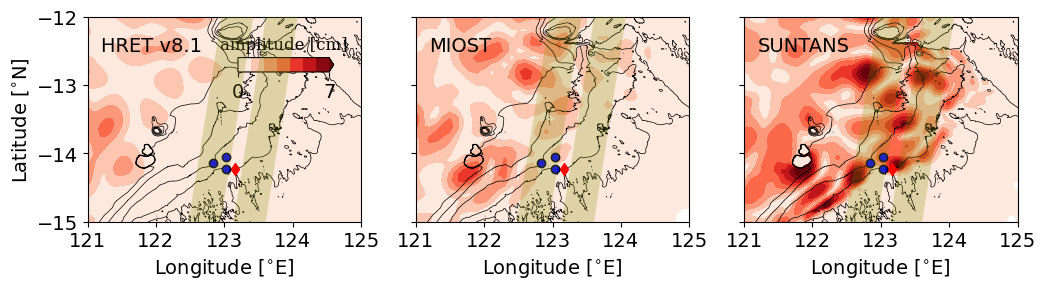

In [27]:
tidecon = 'M2'

plt.figure(figsize=(12,6))
ax1=plt.subplot(131)
plot_hret(ax1,ds_hret, tidecon, vmax=7, clevs=8 )
ax1.text(121.2, -12.5, 'HRET v8.1')

ax2=plt.subplot(133)
plot_sun_var(ax2, sunamp[indx[tidecon],...]*1e2, \
             'SUNTANS\n{} amplitude [cm]'.format(tidecon), vmax=7, clevs=8, \
             cmap='Reds', fontcolor='k', extend='max',
            xlims=xlims, ylims=ylims)
# plt.text(0.02,1.02,'(a)', transform=ax.transAxes)
ax2.set_ylabel('')
ax2.set_yticklabels([])
ax2.text(121.2, -12.5, 'SUNTANS')

ax3=plt.subplot(132)
plot_miost(ax3, miost_ds)
ax3.set_ylabel('')
ax3.set_yticklabels([])
ax3.text(121.2, -12.5, 'MIOST')

# plt.tight_layout()
plt.savefig('../FIGURES/HRET_vs_SUNTANS_vs_MIOST_M2.png',dpi=150)

In [20]:
miost_ds

<xarray.Dataset>
Dimensions:    (lat: 31, lon: 41, nv: 2)
Coordinates:
  * lat        (lat) float64 -15.0 -14.9 -14.8 -14.7 ... -12.3 -12.2 -12.1 -12.0
  * lon        (lon) float64 121.0 121.1 121.2 121.3 ... 124.7 124.8 124.9 125.0
  * nv         (nv) int32 0 1
Data variables:
    lat_bnds   (lat, nv) float32 ...
    lon_bnds   (lon, nv) float32 ...
    crs        int32 ...
    amplitude  (lat, lon) float64 1.791 1.621 1.093 0.3762 ... 0.269 0.42 0.4657
    phase      (lat, lon) float64 ...
Attributes: (12/18)
    cdm_data_type:              Grid
    license:                    http://www.aviso.oceanobs.com/fileadmin/docum...
    product_version:            1.0
    project:                    DUACS
    title:                      MIOST-IT baroclinic tide elevations
    summary:                    Global internal tide solution based on a simu...
    ...                         ...
    Metadata_Conventions:       Unidata Dataset Discovery v1.0
    Conventions:                CF-1.6
    geospatial_lat_units:       degrees_north
    geospatial_lon_units:       degrees_east
    geospatial_lat_resolution:  0.1
    geospatial_lon_resolution:  0.1